In [2]:
N = 3000  # number_of_columns_to_selected_in_termDocumentMatrix
target = 'identity_hate'

In [2]:
import textmining
import nltk
import string
import numpy as np
from textblob import TextBlob
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.feature_selection import SelectFromModel

In [4]:
data = pd.read_csv("./Dataset/train.csv")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
data = data.loc[:, 'id':'identity_hate']
d1 = data.loc[data[target] == 1]
d2 = data.loc[data[target] == 0]
d1.shape
d2.shape[0]
d3 = d1.append(d2[0:d1.shape[0]])
d3.shape
d3.groupby(target).size()
d3 = d3.sort_index()

data = d3.copy()
del([d1,d2,d3])

In [7]:
data.index = range(0, data.shape[0])

In [8]:
id_column = data[['id']]
id_column.shape

(2810, 1)

In [9]:
data.groupby(target).size()

identity_hate
0    1405
1    1405
dtype: int64

# Pre-processing

In [10]:
stopwd = set(stopwords.words("english"))
punctuations = set(string.punctuation)

In [11]:
def clean(doc):
    stopwd_free = " ".join([i for i in doc.lower().split() if i not in stopwd])
    punc_free = "".join(i for i in stopwd_free if i not in punctuations)
    num_free = "".join(i for i in punc_free if not i.isdigit())
    return num_free

In [12]:
data_corpus = [clean(data.iloc[i,1]) for i in range(0, data.shape[0])]

In [13]:
data['comment_text'] = data_corpus

In [14]:
vectorizer = CountVectorizer(min_df=2, max_features=N)
vec = vectorizer.fit(data['comment_text'])

In [15]:
X = vec.transform(data['comment_text'])
X.shape

(2810, 3000)

In [16]:
train_tdm_all_features = vec.get_feature_names()          
len(train_tdm_all_features)

3000

In [17]:
df_tdm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [18]:
df_tdm[target] = data[target]
df_tdm[target] = np.where(df_tdm[target] == 0.0, 0, 1)

In [19]:
df_tdm['id'] = id_column
df_tdm.head()

,abc,abe,able,about,above,absence,absolute,absolutely,absurd,abuse,...,you,young,younger,youre,yourself,youth,youtube,zero,zionist,identity_hate
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# Splitting into train and test data

In [20]:
training_data = df_tdm.sample(n= int(0.8*(df_tdm.shape[0])), random_state=7)
training_data.head()

,abc,abe,able,about,above,absence,absolute,absolutely,absurd,abuse,...,you,young,younger,youre,yourself,youth,youtube,zero,zionist,identity_hate
855,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1354,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1576,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
index_of_training_data = training_data.index
index_of_testing_data = [index for index in df_tdm.index if index not in index_of_training_data]
test_data = df_tdm.loc[index_of_testing_data]
test_data.head()

,abc,abe,able,about,above,absence,absolute,absolutely,absurd,abuse,...,you,young,younger,youre,yourself,youth,youtube,zero,zionist,identity_hate
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [22]:
df_tdm.groupby([target]).size()

identity_hate
0    1405
1    1405
dtype: int64

In [23]:
training_data.groupby([target]).size()

identity_hate
0    1130
1    1118
dtype: int64

In [24]:
test_data.groupby([target]).size()

identity_hate
0    275
1    287
dtype: int64

# Creating Model

In [25]:
predictors = [x for x in df_tdm.columns if x not in [target, 'id']]
len(predictors)

2999

In [26]:
xgb_model01 = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=250, silent=False, 
                            objective='binary:logistic', n_jobs=-1, gamma=0, min_child_weight=1, 
                            subsample=0.8, colsample_bytree=0.8, seed=5)

In [27]:
xgb_params = xgb_model01.get_xgb_params()
xgtrain = xgb.DMatrix(pd.DataFrame(training_data[predictors]), label=training_data[target].values)
cvresult = xgb.cv(params=xgb_params, dtrain=xgtrain, num_boost_round=xgb_model01.get_params()['n_estimators'], nfold=5, 
                  stratified=False, folds=None, metrics='auc', obj=None, feval=None, 
                  maximize=False, early_stopping_rounds=50, verbose_eval=True)
xgb_model01.set_params(n_estimators=cvresult.shape[0])   

#Fit the xgb_model01 algorithm on the data
xgb_model01.fit(X=training_data[predictors], 
        y=training_data[target], 
        eval_metric='auc')


[0]	train-auc:0.760269+0.0115799	test-auc:0.751705+0.0321907
[1]	train-auc:0.800624+0.00691852	test-auc:0.797925+0.0184101
[2]	train-auc:0.821747+0.018512	test-auc:0.81954+0.00602213
[3]	train-auc:0.832123+0.0120664	test-auc:0.824915+0.00956676
[4]	train-auc:0.845578+0.0093945	test-auc:0.83675+0.00967888
[5]	train-auc:0.862987+0.00889485	test-auc:0.852643+0.00867399
[6]	train-auc:0.87024+0.00869317	test-auc:0.856005+0.0123175
[7]	train-auc:0.874809+0.00973611	test-auc:0.860059+0.013455
[8]	train-auc:0.877643+0.0117361	test-auc:0.861204+0.0142857
[9]	train-auc:0.885452+0.00613244	test-auc:0.869655+0.0160986
[10]	train-auc:0.888385+0.00813446	test-auc:0.869648+0.0178183
[11]	train-auc:0.892378+0.00960655	test-auc:0.874071+0.0111694
[12]	train-auc:0.89978+0.00630841	test-auc:0.881571+0.0175494
[13]	train-auc:0.90226+0.00506213	test-auc:0.885234+0.0179493
[14]	train-auc:0.908674+0.00603204	test-auc:0.89142+0.017605
[15]	train-auc:0.912402+0.00659877	test-auc:0.894774+0.0150476
[16]	train-a

[130]	train-auc:0.979381+0.00150641	test-auc:0.951272+0.00856631
[131]	train-auc:0.979435+0.00147161	test-auc:0.951574+0.00819282
[132]	train-auc:0.979536+0.00150656	test-auc:0.951705+0.00808239
[133]	train-auc:0.979715+0.00158579	test-auc:0.951825+0.00814864
[134]	train-auc:0.97978+0.00157509	test-auc:0.951845+0.00811976
[135]	train-auc:0.979888+0.00156276	test-auc:0.951732+0.00812004
[136]	train-auc:0.980003+0.00151727	test-auc:0.952128+0.00791152
[137]	train-auc:0.980051+0.00153277	test-auc:0.952271+0.00815495
[138]	train-auc:0.980114+0.00148429	test-auc:0.952203+0.00825358
[139]	train-auc:0.980225+0.00144041	test-auc:0.952116+0.00827925
[140]	train-auc:0.980267+0.00144845	test-auc:0.952207+0.008285
[141]	train-auc:0.980368+0.00145531	test-auc:0.952386+0.00818483
[142]	train-auc:0.980478+0.0014523	test-auc:0.952362+0.00809235
[143]	train-auc:0.980541+0.00143966	test-auc:0.952378+0.00812197
[144]	train-auc:0.980599+0.00144211	test-auc:0.952472+0.0082493
[145]	train-auc:0.980685+0.001

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=5, silent=False, subsample=0.8)

###### Feature Importance Graph

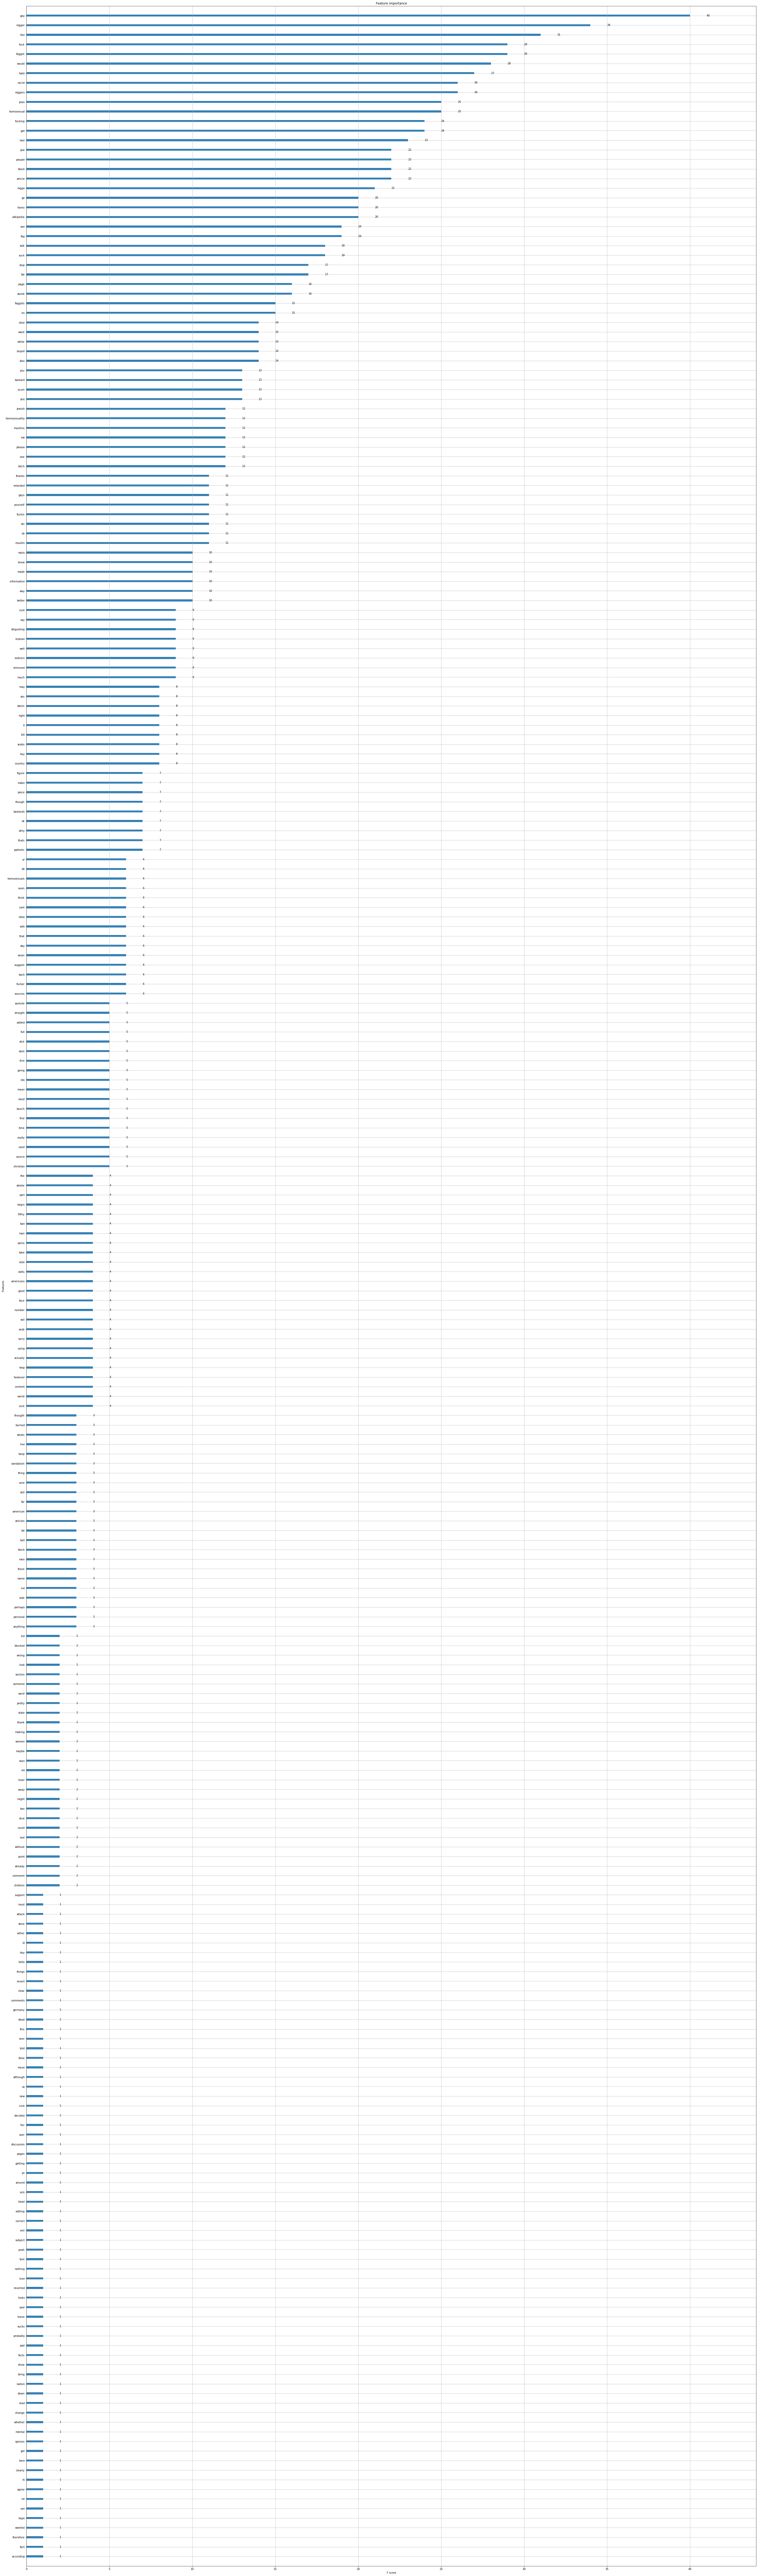

In [28]:
rcParams['figure.figsize'] = 50,180
xgb.plot_importance(xgb_model01.get_booster())

In [29]:
#Predict training set:
train_predictions = xgb_model01.predict(training_data[predictors])
train_predprob = xgb_model01.predict_proba(training_data[predictors])[:, 1]  

#Print model report:
acc = float(accuracy_score(training_data[target], train_predictions)) * 100
AUC = float(roc_auc_score(training_data[target], train_predprob, average='weighted')) * 100
f1 = float(f1_score(training_data[target], train_predictions, average='weighted')) * 100

print("\nModel Report (TRAIN) :\n")
print("Accurary : %.6g" % acc)
print("AUC Score : %.6g" % AUC)
print("F1 Score : %.6g" % f1)

# Predicting on test data:
test_predictions = xgb_model01.predict(test_data[predictors])
test_predprob = xgb_model01.predict_proba(test_data[predictors])[:, 1] 

#Print model report:
acc = float(accuracy_score(test_data[target], test_predictions)) * 100
AUC = float(roc_auc_score(test_data[target], test_predprob, average='weighted')) * 100
f1 = float(f1_score(test_data[target], test_predictions, average='weighted')) * 100

print("\nModel Report (TEST) : \n")
print("Accurary : %.6g" % acc)
print("AUC Score : %.6g" % AUC)
print("F1 Score : %.6g" % f1)

C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report (TRAIN) :

Accurary : 93.6833
AUC Score : 98.6252
F1 Score : 93.6761

Model Report (TEST) : 

Accurary : 89.6797
AUC Score : 94.994
F1 Score : 89.6651


C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Saving Model

In [32]:
path = './model pickle/'
filename = path + "XGBClassifier_equalData_" + target + "_" + str(N) + "_F1_Score" + str(format(f1, '.6g'))
joblib.dump(xgb_model01, filename)

['./model pickle/XGBClassifier_equalData_identity_hate_3000_F1_Score89.6651']

# Loading Model

In [32]:
# path = './model pickle/'
# filename = path + 'XGBClassifier_equalData_toxic_3000_F1_Score87.6949'
# xgb_model01 = joblib.load(filename)

# Probability prediction for test.csv provided by kaggle

In [33]:
testCSV = pd.read_csv('./Dataset/test.csv')

In [34]:
testCSV.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [35]:
testCSV.shape

(153164, 2)

### Pre-processing

In [36]:
data_corpus_testCSV = [clean(testCSV.iloc[i,1]) for i in range(0, testCSV.shape[0])]

In [37]:
testCSV['comment_text'] = data_corpus_testCSV

In [38]:
testCSV.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful ever whats hating s...
1,0000247867823ef7,rfc title fine is imo
2,00013b17ad220c46,sources zawe ashton lapland —
3,00017563c3f7919a,if look back source information updated correc...
4,00017695ad8997eb,anonymously edit articles all


In [42]:
vectorizer = CountVectorizer(min_df=2, max_features=N, vocabulary=train_tdm_all_features) 
vec = vectorizer.fit(testCSV['comment_text'])

In [43]:
X = vec.transform(testCSV['comment_text'])
X.shape

(153164, 3000)

In [44]:
df_tdm_testCSV = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [45]:
df_tdm_testCSV.id = testCSV.id

In [46]:
predictors_for_testCSV = [x for x in df_tdm_testCSV.columns if x not in [target, 'id']]

In [47]:
df_tdm_testCSV[predictors_for_testCSV].shape

(153164, 2999)

In [49]:
df_tdm_testCSV.head()

,abc,abe,able,about,above,absence,absolute,absolutely,absurd,abuse,...,york,you,young,younger,youre,yourself,youth,youtube,zero,zionist
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
prediction_final = xgb_model01.predict_proba((df_tdm_testCSV[predictors_for_testCSV]))[:,1]

In [51]:
final_submission = pd.read_csv('./sample_submission.csv')

In [52]:
final_submission[target] = prediction_final

In [53]:
final_submission.head()

,Unnamed: 0,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,00001cee341fdb12,0.999996,0.945681,0.998782,0.933109,0.999919,0.984416
1,1,0000247867823ef7,0.166511,0.245883,0.245466,0.225509,0.188381,0.283601
2,2,00013b17ad220c46,0.266785,0.245883,0.213822,0.156009,0.254462,0.224456
3,3,00017563c3f7919a,0.071220,0.223626,0.091228,0.491236,0.032124,0.065615
4,4,00017695ad8997eb,0.327090,0.121694,0.182571,0.067571,0.218125,0.211494


In [54]:
final_submission = final_submission.drop(['Unnamed: 0'], axis=1)

In [55]:
final_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999996,0.945681,0.998782,0.933109,0.999919,0.984416
1,0000247867823ef7,0.166511,0.245883,0.245466,0.225509,0.188381,0.283601
2,00013b17ad220c46,0.266785,0.245883,0.213822,0.156009,0.254462,0.224456
3,00017563c3f7919a,0.071220,0.223626,0.091228,0.491236,0.032124,0.065615
4,00017695ad8997eb,0.327090,0.121694,0.182571,0.067571,0.218125,0.211494


###### Saving csv file on the disk

In [14]:
final_submission.to_csv('./sample_submission.csv', index=False)